# Example of model selection using cross-validation with RecTools

- CV split
- Training a variety of models
- Measuring a variety of metrics

In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel
from rectools.model_selection import TimeRangeSplitter

## Load data

In [26]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
CPU times: user 30.3 ms, sys: 66.5 ms, total: 96.8 ms
Wall time: 3.23 s


In [22]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings.head()

(1000209, 4)
CPU times: user 4.78 s, sys: 365 ms, total: 5.15 s
Wall time: 5.15 s


user_id  item_id  weight   datetime
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291

In [23]:
ratings["user_id"].nunique(), ratings["item_id"].nunique()

(6040, 3706)

In [24]:
ratings["weight"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: weight, dtype: int64

In [25]:
ratings["datetime"] = pd.to_datetime(ratings["datetime"] * 10 ** 9)
print("Time period")
ratings["datetime"].min(), ratings["datetime"].max()

Time period


(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

Optimize dataframe for further usage. `Interactions` will cast types and save new `pd.DataFrame` inside in `Interactions.df`

In [26]:
interactions = Interactions(ratings)
del ratings
interactions.df.head()

user_id  item_id  weight            datetime
0        1     1193     5.0 2000-12-31 22:12:40
1        1      661     3.0 2000-12-31 22:35:09
2        1      914     3.0 2000-12-31 22:32:48
3        1     3408     4.0 2000-12-31 22:04:35
4        1     2355     5.0 2001-01-06 23:38:11

## Split interactions for CV

We'll use last 3 periods of 2 weeks to validate our models.

In [27]:
n_splits = 3

cv = TimeRangeSplitter(
    test_size="14D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [28]:
cv.get_test_fold_borders(interactions)

[(Timestamp('2003-01-18 00:00:00', freq='14D'),
  Timestamp('2003-02-01 00:00:00', freq='14D')),
 (Timestamp('2003-02-01 00:00:00', freq='14D'),
  Timestamp('2003-02-15 00:00:00', freq='14D')),
 (Timestamp('2003-02-15 00:00:00', freq='14D'),
  Timestamp('2003-03-01 00:00:00', freq='14D'))]

## Train models

In [29]:
# Take few simple models to compare
models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)),
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

K_RECOS = 10

In [30]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

results = []

fold_iterator = cv.split(interactions, collect_fold_stats=True)

for train_ids, test_ids, fold_info in tqdm((fold_iterator), total=n_splits):
    print(f"\n==================== Fold {fold_info['i_split']}")
    pprint(fold_info)

    df_train = interactions.df.iloc[train_ids]
    dataset = Dataset.construct(df_train)

    df_test = interactions.df.iloc[test_ids][Columns.UserItem]
    test_users = np.unique(df_test[Columns.User])

    # Catalog is set of items that we recommend.
    # Sometimes we recommend not all items from train.
    catalog = df_train[Columns.Item].unique()

    for model_name, model in models.items():
        model.fit(dataset)
        recos = model.recommend(
            users=test_users,
            dataset=dataset,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
        res = {"fold": fold_info["i_split"], "model": model_name}
        res.update(metric_values)
        results.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]


==================== Fold 0
{'end': Timestamp('2003-02-01 00:00:00', freq='14D'),
 'i_split': 0,
 'start': Timestamp('2003-01-18 00:00:00', freq='14D'),
 'test': 630,
 'test_items': 540,
 'test_users': 75,
 'train': 998083,
 'train_items': 3706,
 'train_users': 6040}


 33%|███▎      | 1/3 [00:02<00:05,  2.61s/it]


==================== Fold 1
{'end': Timestamp('2003-02-15 00:00:00', freq='14D'),
 'i_split': 1,
 'start': Timestamp('2003-02-01 00:00:00', freq='14D'),
 'test': 899,
 'test_items': 704,
 'test_users': 57,
 'train': 998713,
 'train_items': 3706,
 'train_users': 6040}


 67%|██████▋   | 2/3 [00:05<00:02,  2.56s/it]


==================== Fold 2
{'end': Timestamp('2003-03-01 00:00:00', freq='14D'),
 'i_split': 2,
 'start': Timestamp('2003-02-15 00:00:00', freq='14D'),
 'test': 597,
 'test_items': 501,
 'test_users': 66,
 'train': 999612,
 'train_items': 3706,
 'train_users': 6040}


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]

CPU times: user 40.7 s, sys: 902 ms, total: 41.6 s
Wall time: 7.62 s


In [31]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns="fold").groupby(["model"], sort=False).agg(["mean", "std"])
mean_metric_subset = [(metric, agg) for metric, agg in pivot_results.columns if agg == 'mean']
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)

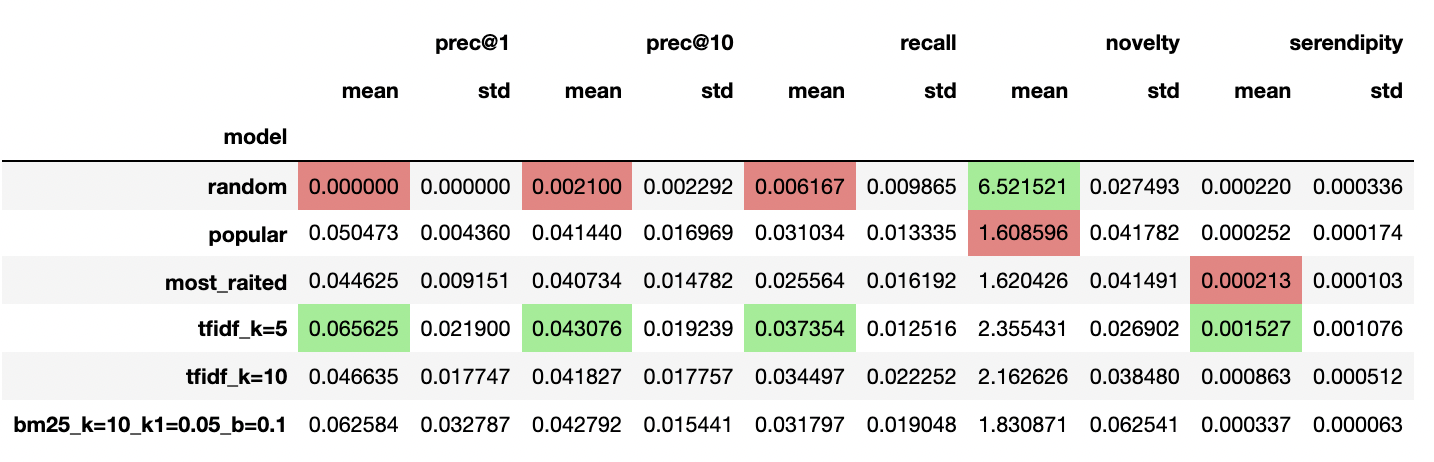